In [1]:
import datacube 
import matplotlib.pyplot as plt
import pandas as pd
import pytz
import numpy as np

from scipy.stats import cumfreq
from otps import TimePoint, predict_tide
# from otps import predict_tide
from dea_tools.dask import create_local_dask_cluster

import sys
sys.path.append("../Tools/dea_tools")
from coastal_temp import (select_aoi, 
                          exp_model, 
                          prep_aoi, 
                          plot_summary)


In [2]:
dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/dev_intexp/dea-notebooks/Real_world_examples/dask-worker-space/worker-eigdjr4p', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46857,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:34845,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/35679/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:37275,


In [3]:
m, master_gdf, roi = select_aoi()
display (m)

Map(center=[-32.13054578933222, 136.10234378608968], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [29]:
## Following selection of your area of interest using the shape options in the map menu
## and your tide-modelling position, using the `marker` option, run this cell to
## prepare the selections for analysis. Note that this is a per-pixel analysis. Consequently,
## a small area of interest is advised to minimise computation time.

tp, working_gdf, geom = prep_aoi(roi, master_gdf)

In [30]:
tp

[152.017404, -32.873802]

In [31]:
## Set the user-defined variables 

## Define the tidal-modelling period start and end dates. This is the period over which intertidal
## exposure will be calculated. Ideally, this period should be an 18.6 year window to account
## for the full average range of astronomical forcings on the tide (e.g. Haigh et al., 2011).
## However, a shorter window is advised in this application to minimise the computation time.
## Note that if a filter is applied to the tide-model, e.g. restricted date or tide range, then
## a wide tidal-modelling period may be achievable on this platform.

## Tidal modelling period. Format: 'YYYY-MM-DD HH:MM:SS'
time_start = '1985-12-01 00:00:00'
time_end = '2023-01-01 00:00:00'

## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq='30min'

# ## Set the filter to apply for the exposure modelling. Options:
'''
    'all_time',
    'daynight',
    'springneap',
    'wet',
    'dry',
    'summer',
    'autumn',
    'winter',
    'spring',
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
'''
time_filter = ['all_time']

query = {
    'product': ['nidem'],
    "dask_chunks": {"time": 1, "x": 100000, "y": 100000},
    "geopolygon": geom
        }

In [32]:
ds = dc.load(**query)
ds2 = ds.where(ds.nidem > ds.nidem.min())

In [33]:
ds2 = ds2.compute()

In [ ]:
# ds.nidem.min()

In [ ]:
# ds.nidem.max()

In [ ]:
ds2.nidem

In [ ]:
# ds2 = ds.where(ds.nidem > ds.nidem.min())

In [ ]:
# ds['nidem'].plot()
ds3 = ds2.squeeze('time')
ds3

In [ ]:
ds2.nidem.plot()

In [ ]:
## Flatten tide-model to 1d
ds4 = ds3.to_array().values.ravel()
## Sort the flattened array (x-axis)

## Calculate the cumulative frequency of the sorted-flattened-array


# type(ds4)

In [ ]:
# # x=np.sort(ds3)
# x=unstacked
# y=unstacked.cumsum()
# plt.plot(x,y)
# # print (type(x))
# # print(x.shape)
# # print (type(y))
# # print(y.shape)
# # ds3=ds3.to_dataset()

In [ ]:
# ds3.nidem#.squeeze('time')

In [ ]:
# stacked=ds3.nidem.stack(z=('y','x'))
# # stacked.indexes['z']
# unstacked=stacked.unstack()
# unstacked
# # # ds3.nidem.identical(unstacked)

In [ ]:
# # ds3
# ds4=ds3.to_stacked_array("z",['x'])

# ds4.indexes['z']

# # ds5=ds4.to_unstacked_dataset(dim='z')

# # ds2.identical(ds5)
# # ds4=ds2.to_unstacked_dataset(dim='time')

In [ ]:
## after https://stackoverflow.com/questions/3209362/how-to-plot-empirical-cdf-ecdf
# x=np.sort(ds3)[::1000]
# # print(x)
# y=np.arange(len(x))/float(len(x))
# plt.plot(x,y)


In [ ]:
# # ds2.nidem.plot.hist()
# type(x)
# x.shape
# # xx = x.to_array()
# # type(xx)

In [ ]:
import xarray as xr

In [ ]:
# pxpc_2001 = xr.open_dataset('2001-12-01 00:00:00_to_2013-01-01 00:00:00.nc')

In [ ]:
# pxpc_2001.nidem.plot.hist()

In [ ]:
# pxpc_2001.all_time.plot.hist()

In [ ]:
# pxpc_1991 = xr.open_dataset('1991-12-01 00:00:00_to_2002-01-01 00:00:00.nc')

In [ ]:
# pxpc_1991.nidem.plot.hist()

In [ ]:
# pxpc_2001.nidem.plot.hist()
# pxpc_1991.all_time.plot.hist()

In [ ]:
# print(pxpc_1991.nidem.min())
# print(pxpc_2001.nidem.max())

In [ ]:
# %store -r modelledtides_all

In [ ]:
# modelledtides_all.plot(figsize=(10,4))

In [ ]:
# modelledtides_all.min()

In [25]:
def exp_model(time_start, 
              time_end, 
              time_filter, 
              modelled_freq, 
              tidepost_lat, 
              tidepost_lon, 
              ds):      
    ## Run tidal modelling

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]
        ## Save modelled tides as dataframe
        ## Firstly convert the dates to series
    all_timerange = all_timerange.to_series()
        ## Save dates and tideheights to pd.DataFrame
    modelledtides = pd.DataFrame(data={'timerange': all_timerange,
                       'tideheights': all_tideheights})
    
    print ('Complete: Tidal modelling. Starting: Local timezone conversion')

    '''---------------------------------------------------------'''
    ## Automate timezone selection based on location of tidepost
    ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
    if tidepost_lon <= 129.0:
        timezone = 'Australia/West'
        local_tz = 8
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/North'
        local_tz = 9.5
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
        timezone = 'Australia/South'
        local_tz = 9.5
    elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/Queensland'
        local_tz = 10
    elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
        timezone = 'Australia/NSW'
        local_tz = 10
    else:
        print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
    print('Timezone set to', timezone)
    
    ## Convert time_start and time_end to datetime objects in local timezone
    time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
    time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
    ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
    localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

    ## Convert tz-aware index to local timezone
    localtides = localtides.tz_convert(timezone)
    
    ## Reset the index of modelledtides to reflect local times
    modelledtides['local_timerange'] = localtides
    modelledtides.set_index('local_timerange', inplace=True)
    modelledtides.drop('timerange', axis=1, inplace=True)
    
    return modelledtides

In [34]:
modelledtides_neg_lat = exp_model(time_start,
                                  time_end,
                                  time_filter,
                                  modelled_freq,
                                  tidepost_lat = tp[1],# = -17.420604,
                                  tidepost_lon = tp[0],# = 140.665169,
                                  ds=ds2)

Complete: Tidal modelling. Starting: Local timezone conversion
Timezone set to Australia/Queensland


In [13]:
## After https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cumfreq.html



In [35]:
## Extract modelled tideheights as np.array
modelledtides = (np.array(modelledtides_neg_lat.tideheights))

## Calculate cumulative frequencies
res = cumfreq(modelledtides, numbins=100)

# Calculate space of values for x
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

In [64]:
res.binsize
# res

0.020545454545454533

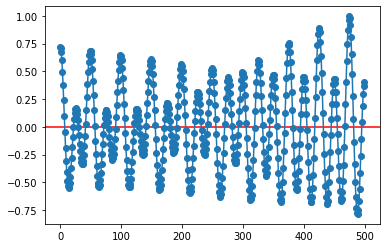

In [75]:
# plt.axhline(y=0.0, linestyle='-', color='r')
# plt.plot(modelledtides[:500], marker='o')

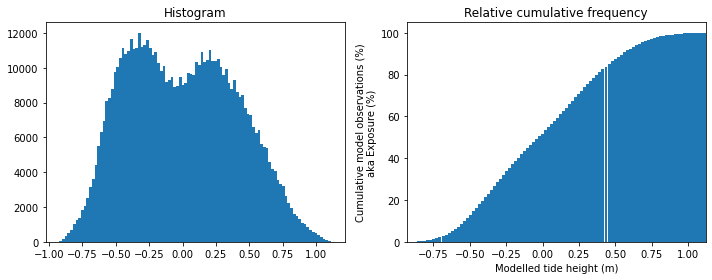

In [36]:
## Newcastle, NSW

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(modelledtides, bins=100)
ax1.set_title('Histogram')
ax2.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)
ax2.set_title('Relative cumulative frequency')
ax2.set_ylabel('Cumulative model observations (%)\naka Exposure (%)')
ax2.set_xlabel('Modelled tide height (m)')
ax2.set_xlim([x.min(), x.max()])
fig.tight_layout()

In [76]:
## Save the relative cumulative frequency dataset as an array to act as a lookup table for the NIDEM heights
testdict={'tideheight': x, 'cumfreq': res.cumcount/len(modelledtides)*100}
test = pd.DataFrame(data=testdict)


<BarContainer object of 100 artists>

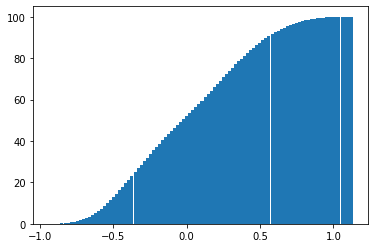

In [79]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.bar(test.tideheight, test.cumfreq, width=res.binsize)

In [19]:
# res.cumcount.size
# len(modelledtides)
# res.lowerlimit==x[0] 
len(res.cumcount/len(modelledtides)*100)

100

In [ ]:
# fig = plt.figure(figsize=(10, 4))
# ax1 = fig.add_subplot(1, 2, 1)
# ax2 = fig.add_subplot(1, 2, 2)
# ax1.hist(modelledtides, bins=100)
# ax1.set_title('Histogram')
# ax2.bar(x, res.cumcount, width=res.binsize)
# ax2.set_title('Cumulative histogram')
# ax2.set_xlim([x.min(), x.max()])

In [ ]:
# ## Plot cumulative frequency of the tides then apply a cdf model (maybe...)

# ## Extract modelled tideheights as np.array
# modelledtides = (np.array(modelledtides_neg_lat.tideheights))

# ## sort 
# x=np.sort(modelledtides)

# y=np.cumsum(x)

# plt.plot(x,y)

In [ ]:
# modelledtides_neg_lat.plot(figsize=(20,4))

In [ ]:
# modelledtides_pos_lat = exp_model(time_start,
#                                   time_end,
#                                   time_filter,
#                                   modelled_freq,
#                                   tidepost_lat = 17.420604,
#                                   tidepost_lon = 140.665169,
#                                   ds=ds2)

In [ ]:
# modelledtides_pos_lat.plot(figsize=(20,4))